<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction - Facebook Challenge</b> </p>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [3]:
!wget --header="Host: doc-0o-bk-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.212 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Cookie: AUTH_nso6dcn1mbidkt5qr539a2jiefc09pqv_nonce=iak2ig7rpq664" --header="Connection: keep-alive" "https://doc-0o-bk-docs.googleusercontent.com/docs/securesc/nss2f5s2soorprev6d4t4qp3n5ekp9nh/evl2j2j4t5hronicnhsbdlsblnbl9qk3/1622116650000/06629147635963609455/13017565264516993811/1fDJptlCFEWNV5UNGPc4geTykgFI3PDCV?e=download&authuser=0&nonce=iak2ig7rpq664&user=13017565264516993811&hash=fvl5s6dohfnqle6k8q3koe9jr2mhe6jr" -c -O 'storage_sample_stage4.h5'

--2021-12-06 11:26:06--  https://doc-0o-bk-docs.googleusercontent.com/docs/securesc/nss2f5s2soorprev6d4t4qp3n5ekp9nh/evl2j2j4t5hronicnhsbdlsblnbl9qk3/1622116650000/06629147635963609455/13017565264516993811/1fDJptlCFEWNV5UNGPc4geTykgFI3PDCV?e=download&authuser=0&nonce=iak2ig7rpq664&user=13017565264516993811&hash=fvl5s6dohfnqle6k8q3koe9jr2mhe6jr
Resolving doc-0o-bk-docs.googleusercontent.com (doc-0o-bk-docs.googleusercontent.com)... 74.125.203.132, 2404:6800:4008:c03::84
Connecting to doc-0o-bk-docs.googleusercontent.com (doc-0o-bk-docs.googleusercontent.com)|74.125.203.132|:443... connected.
HTTP request sent, awaiting response... 403 Forbidden
2021-12-06 11:26:06 ERROR 403: Forbidden.



In [4]:
if os.path.isfile('/content/drive/My Drive/Facebook/data/after_eda/train_pos_after_eda.csv'):
    train_graph=nx.read_edgelist('/content/drive/My Drive/Facebook/data/after_eda/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(train_graph))
else:
    print("please run the FB_EDA.ipynb or download the files from drive")

DiGraph with 1780722 nodes and 7550015 edges


In [5]:
#reading
from pandas import read_hdf
df_final_train = read_hdf('/content/drive/MyDrive/Facebook/data/fea_sample/storage_sample_stage4.h5', 'train_df',mode='r')
df_final_test = read_hdf('/content/drive/MyDrive/Facebook/data/fea_sample/storage_sample_stage4.h5', 'test_df',mode='r')

In [6]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6'],
      dtype='object')

Computing followers destination as num_follower_d

In [7]:
def compute_feature_followers_d(df_final):
    #calculating no of followers followees for source and destination
    #calculating intersection of followers and followees for source and destination
    num_followers_d=[]
    
    for i,row in df_final.iterrows():
        try:
              d1=set(train_graph.predecessors(row['destination_node']))
        except:
              d1 = set()

        num_followers_d.append(len(d1))
    
    return num_followers_d


Creating the feature num_follower_d in the datasets

In [8]:
df_final_train['num_followers_d'] = compute_feature_followers_d(df_final_train)
df_final_test['num_followers_d'] = compute_feature_followers_d(df_final_test)

In [9]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [10]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

In [11]:
df_final_train.columns

Index(['jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'num_followers_d'],
      dtype='object')

In [12]:
df_final_train.head()

,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,follows_back,same_comp,shortest_path,weight_in,weight_out,weight_f1,weight_f2,weight_f3,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d,svd_u_s_1,svd_u_s_2,svd_u_s_3,svd_u_s_4,svd_u_s_5,svd_u_s_6,svd_u_d_1,svd_u_d_2,svd_u_d_3,svd_u_d_4,svd_u_d_5,svd_u_d_6,svd_v_s_1,svd_v_s_2,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,num_followers_d
0,0,0.000000,0.000000,0.000000,6,15,8,0,0,0.000000,0,1,4,0.377964,0.250000,0.627964,0.094491,1.005929,0.877964,2.045290e-06,3.459963e-07,0.000773,0.000756,1.943132e-13,1.941103e-13,9.226339e-16,2.231877e-15,-1.666226e-13,4.613397e-13,1.043044e-05,6.676960e-13,2.451081e-13,3.584580e-12,-2.038017e-11,5.397495e-13,1.068946e-06,1.192357e-12,2.279485e-12,3.580837e-12,-7.216133e-13,3.925975e-13,1.983691e-06,1.545075e-13,8.108434e-13,1.719702e-14,-1.355368e-12,4.675307e-13,1.128591e-06,6.616550e-14,9.771077e-13,4.159752e-14,6
1,0,0.187135,0.028382,0.343828,94,61,142,11,32,16.362912,0,1,2,0.102598,0.127000,0.229598,0.013030,0.332196,0.356598,2.353458e-07,6.427660e-07,0.000845,0.001317,3.906648e-11,9.424102e-11,1.208074e-11,1.273080e-10,7.051088e-13,-8.250564e-11,-1.717702e-10,3.705016e-02,1.032392e-11,7.207497e-10,1.644399e-12,-2.047752e-10,-3.943936e-10,8.617541e-02,2.399540e-11,1.738682e-09,2.685878e-13,-3.316849e-11,-6.236048e-11,1.345726e-02,3.703479e-12,2.251737e-10,1.245101e-12,-1.636948e-10,-3.112650e-10,6.738902e-02,2.607801e-11,2.372904e-09,94
2,0,0.369565,0.156957,0.566038,28,41,22,26,17,10.991826,0,1,2,0.185695,0.154303,0.339999,0.028653,0.525694,0.494302,6.211019e-07,5.179801e-07,0.000885,0.000855,7.730764e-114,4.067322e-114,2.681298e-113,2.199205e-113,-4.900734e-18,1.096831e-18,-6.816555e-19,-2.226453e-18,6.710556e-19,-8.161336e-19,-2.606312e-18,6.392474e-19,-4.245830e-19,-1.315747e-18,3.849627e-19,-1.131971e-18,-1.510265e-18,1.454979e-19,-2.380564e-19,-7.021227e-19,1.940403e-19,-3.365389e-19,-1.238370e-18,1.438175e-19,-1.852863e-19,-5.901864e-19,1.629341e-19,-2.572452e-19,28
3,0,0.000000,0.000000,0.000000,11,5,7,0,0,0.000000,0,1,6,0.288675,0.408248,0.696923,0.117851,0.985599,1.105172,2.998153e-07,1.704245e-06,0.000739,0.000773,5.443738e-17,4.139999e-16,2.413250e-14,6.688064e-15,-9.965436e-12,4.077137e-13,5.083778e-10,1.985267e-14,2.471968e-12,1.004354e-15,-2.629029e-13,1.428940e-11,9.146784e-11,8.590132e-12,2.406658e-10,7.638106e-15,-2.170899e-13,5.206150e-13,6.058498e-11,1.514614e-11,1.513483e-12,4.498061e-13,-9.818087e-10,3.454672e-11,5.213635e-08,9.595823e-13,3.047045e-10,1.246592e-13,11
4,0,0.000000,0.000000,0.000000,1,11,3,0,0,0.000000,0,0,-1,1.000000,0.301511,1.301511,0.301511,2.301511,1.603023,4.349180e-07,2.089590e-07,0.000751,0.000735,3.887821e-16,4.721269e-16,7.552255e-16,2.734009e-18,-3.408943e-13,1.125207e-13,3.190883e-07,8.550846e-14,1.405351e-13,7.172313e-15,-2.550169e-13,2.424636e-13,2.436301e-07,3.679960e-14,1.348520e-13,8.710393e-15,-4.795514e-13,1.521297e-13,1.197283e-07,1.999809e-14,3.360247e-13,1.407670e-14,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1


Estimators =  10 Train Score 0.8998228982185643 test Score 0.8807561084150969
Estimators =  50 Train Score 0.9221938109899285 test Score 0.896376378087343
Estimators =  100 Train Score 0.9217030676892297 test Score 0.8920666181444535
Estimators =  250 Train Score 0.9211923915651965 test Score 0.8978843982359332
Estimators =  450 Train Score 0.921393097116147 test Score 0.8965737935742629


Text(0.5, 1.0, 'Estimators vs score at depth of 5')

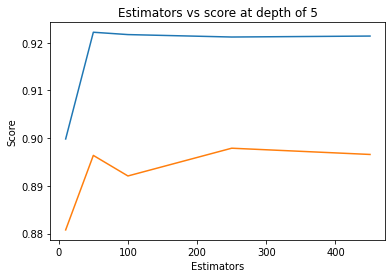

In [46]:
estimators = [10,50,100,250,450]
train_scores = []
test_scores = []
for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, 
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

depth =  3 Train Score 0.8591331103964785 test Score 0.8455702768712041
depth =  9 Train Score 0.9544731042363888 test Score 0.9073916012290885
depth =  11 Train Score 0.9612323023637358 test Score 0.9043091845236825
depth =  15 Train Score 0.9628886456686531 test Score 0.9230607304494263
depth =  20 Train Score 0.9630710017218679 test Score 0.912221773422054
depth =  35 Train Score 0.9630740241715715 test Score 0.914982504506415
depth =  50 Train Score 0.9630740241715715 test Score 0.914982504506415
depth =  70 Train Score 0.9630740241715715 test Score 0.914982504506415
depth =  130 Train Score 0.9630740241715715 test Score 0.914982504506415


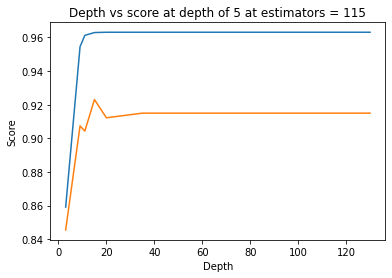

In [47]:
depths = [3,9,11,15,20,35,50,70,130]
train_scores = []
test_scores = []
for i in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=i, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, 
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=115, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 115')
plt.show()

In [48]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',random_state=25, return_train_score=True)

rf_random.fit(df_final_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
print('mean train scores',rf_random.cv_results_['mean_train_score'])

mean test scores [0.96194014 0.9619085  0.96016482 0.96140897 0.96278416]
mean train scores [0.96256705 0.96228858 0.96048132 0.96179993 0.96347628]


In [49]:
print(rf_random.best_estimator_)

RandomForestClassifier(max_depth=14, min_samples_leaf=28, min_samples_split=111,
                       n_estimators=121, n_jobs=-1, random_state=25)


In [50]:
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, 
            min_samples_leaf=28, min_samples_split=111,
            min_weight_fraction_leaf=0.0, n_estimators=121, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)

In [51]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [52]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9629269970361829
Test f1 score 0.9073149925357218


In [53]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


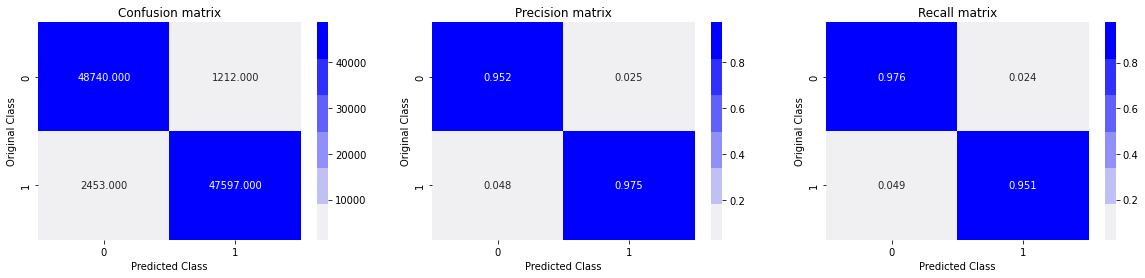

Test confusion_matrix


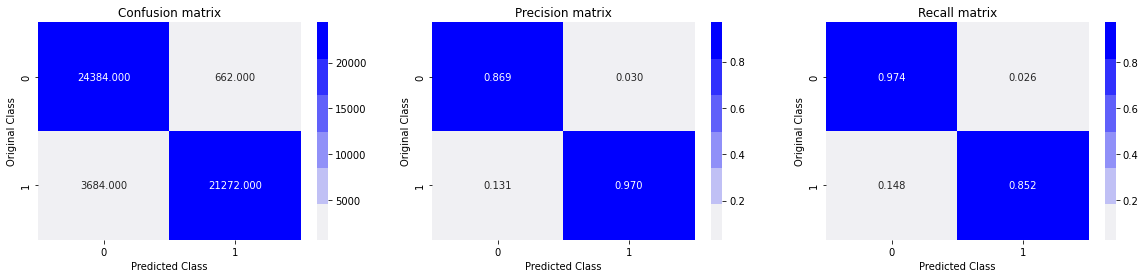

In [54]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

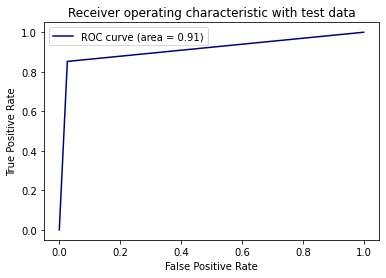

In [55]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

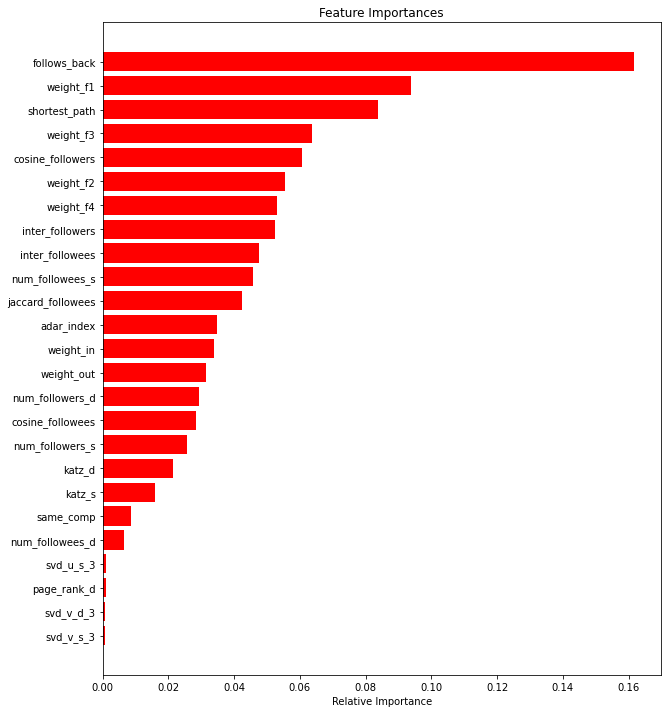

In [56]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Assignments:

1. Add another feature called  Preferential Attachment  with followers and followees data of vertex. you can check about Preferential Attachment in below link
http://be.amazd.com/link-prediction/ <br>
2. Add  feature called svd_dot. you can calculate svd_dot as Dot product between sourse node svd and destination node svd features.  you can read about this in below pdf 
https://storage.googleapis.com/kaggle-forum-message-attachments/2594/supervised_link_prediction.pdf<br>
3. Tune hyperparameters for XG boost with all these features and check the error metric.

Preferential Attachment 

In [13]:
#for followees
def preferential_attachment_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = set(train_graph.successors(a))*set(train_graph.successors(b))
    except:
        return 0
    return sim

In [14]:
#for followers
def preferential_attachment_for_followers(a,b):
    try:
        if len(set(train_graph.predecessors(a))) == 0  | len(set(g.predecessors(b))) == 0:
            return 0
        sim = set(train_graph.predecessors(a))*set(train_graph.predecessors(b))
        return sim
    except:
        return 0

In [15]:
df_final_train['preferential_attachment_for_followees'] = df_final_train.apply(lambda row:
                                            preferential_attachment_for_followees(row['num_followers_s'],row['num_followers_d']),axis=1)
df_final_test['preferential_attachment_for_followees'] = df_final_test.apply(lambda row:
                                            preferential_attachment_for_followees(row['num_followers_s'],row['num_followers_d']),axis=1)

In [16]:
df_final_train['preferential_attachment_for_followers'] = df_final_train.apply(lambda row:
                                            preferential_attachment_for_followers(row['num_followees_s'],row['num_followees_d']),axis=1)
df_final_test['preferential_attachment_for_followers'] = df_final_test.apply(lambda row:
                                            preferential_attachment_for_followers(row['num_followees_s'],row['num_followees_d']),axis=1)

SVD Dot

In [19]:
def svd_dot_prod(a,b):
  return np.dot(a,b)

In [20]:
df_final_train['svd_dot_u'] = df_final_train.apply(lambda row:
                                            svd_dot_prod(df_final_train['svd_u_s_1'],df_final_train['svd_u_d_1']) + \
                                            svd_dot_prod(df_final_train['svd_u_s_2'],df_final_train['svd_u_d_2']) + \
                                            svd_dot_prod(df_final_train['svd_u_s_3'],df_final_train['svd_u_d_3']) + \
                                            svd_dot_prod(df_final_train['svd_u_s_4'],df_final_train['svd_u_d_4']) + \
                                            svd_dot_prod(df_final_train['svd_u_s_5'],df_final_train['svd_u_d_5']) + \
                                            svd_dot_prod(df_final_train['svd_u_s_6'],df_final_train['svd_u_d_6']),axis=1)

In [21]:
df_final_train['svd_dot_v'] = df_final_train.apply(lambda row:
                                            svd_dot_prod(df_final_train['svd_v_s_1'],df_final_train['svd_v_d_1']) + \
                                            svd_dot_prod(df_final_train['svd_v_s_2'],df_final_train['svd_v_d_2']) + \
                                            svd_dot_prod(df_final_train['svd_v_s_3'],df_final_train['svd_v_d_3']) + \
                                            svd_dot_prod(df_final_train['svd_v_s_4'],df_final_train['svd_v_d_4']) + \
                                            svd_dot_prod(df_final_train['svd_v_s_5'],df_final_train['svd_v_d_5']) + \
                                            svd_dot_prod(df_final_train['svd_v_s_6'],df_final_train['svd_v_d_6']),axis=1)

Creating svd_dot feature for test data

In [22]:
df_final_test['svd_dot_u'] = df_final_test.apply(lambda row:
                                            svd_dot_prod(df_final_test['svd_u_s_1'],df_final_test['svd_u_d_1']) + \
                                            svd_dot_prod(df_final_test['svd_u_s_2'],df_final_test['svd_u_d_2']) + \
                                            svd_dot_prod(df_final_test['svd_u_s_3'],df_final_test['svd_u_d_3']) + \
                                            svd_dot_prod(df_final_test['svd_u_s_4'],df_final_test['svd_u_d_4']) + \
                                            svd_dot_prod(df_final_test['svd_u_s_5'],df_final_test['svd_u_d_5']) + \
                                            svd_dot_prod(df_final_test['svd_u_s_6'],df_final_test['svd_u_d_6']),axis=1)

In [23]:
df_final_test['svd_dot_v'] = df_final_test.apply(lambda row:
                                            svd_dot_prod(df_final_test['svd_v_s_1'],df_final_test['svd_v_d_1']) + \
                                            svd_dot_prod(df_final_test['svd_v_s_2'],df_final_test['svd_v_d_2']) + \
                                            svd_dot_prod(df_final_test['svd_v_s_3'],df_final_test['svd_v_d_3']) + \
                                            svd_dot_prod(df_final_test['svd_v_s_4'],df_final_test['svd_v_d_4']) + \
                                            svd_dot_prod(df_final_test['svd_v_s_5'],df_final_test['svd_v_d_5']) + \
                                            svd_dot_prod(df_final_test['svd_v_s_6'],df_final_test['svd_v_d_6']),axis=1)

Hyperparameter tunning with xgboost model with RandomSearchCV

In [59]:
from scipy.stats import randint as sp_randint

xgb_clf = XGBClassifier()

prams = {
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2,1],
    'n_estimators':sp_randint(50,200),
    'max_depth':sp_randint(10,50),
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}
random_xgb_clf = RandomizedSearchCV(xgb_clf, param_distributions = prams, n_iter=5, cv=10, random_state=25,
                                 verbose=10, n_jobs=-1, scoring='f1', return_train_score=True)
random_xgb_clf.fit(df_final_train,y_train)

print('mean test scores',random_xgb_clf.cv_results_['mean_test_score'])
print('mean train scores',random_xgb_clf.cv_results_['mean_train_score'])

Fitting 10 folds for each of 5 candidates, totalling 50 fits
mean test scores [0.95772738 0.98059122 0.98011793 0.97531471 0.97662891]
mean train scores [0.99429942 0.99995116 1.         0.98128098 0.99961711]


In [60]:
print (random_xgb_clf.best_params_)

{'colsample_bytree': 0.5, 'learning_rate': 0.15, 'max_depth': 18, 'n_estimators': 182, 'subsample': 0.3}


In [61]:
xgb_clf_best_model = XGBClassifier(learning_rate=0.15, n_estimators=182, max_depth=18,
                     subsample=0.3, colsample_bytree=0.5)
xgb_clf_best_model.fit(df_final_train,y_train)
y_train_pred_xgb = xgb_clf_best_model.predict(df_final_train)
y_test_pred_xgb = xgb_clf_best_model.predict(df_final_test)

In [62]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred_xgb))
print('Test f1 score',f1_score(y_test,y_test_pred_xgb))

Train f1 score 0.9999500524449328
Test f1 score 0.9268158201675325


In [63]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


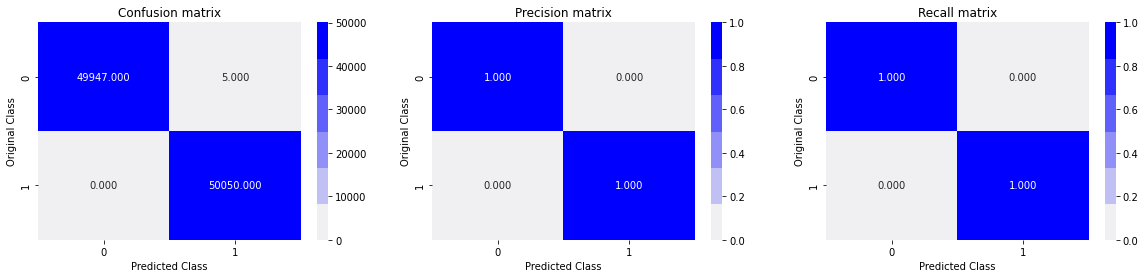

Test confusion_matrix


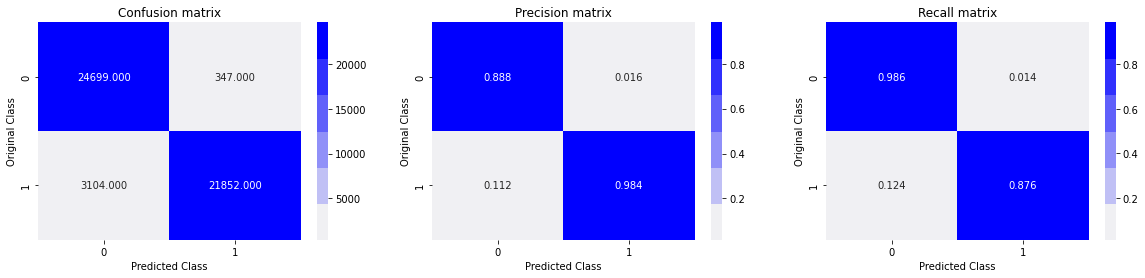

In [64]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred_xgb)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred_xgb)

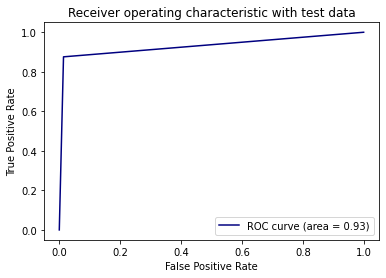

In [65]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred_xgb)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

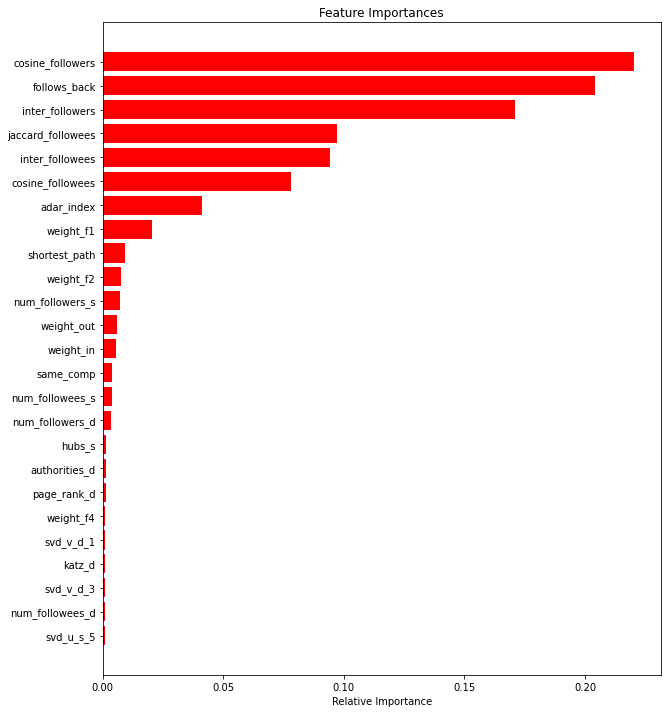

In [66]:
features = df_final_train.columns
importances = xgb_clf_best_model.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [76]:
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ['MODEL','max_depth','n_estimators','Train f1 score','Test f1 score']
table.add_row(['Random forest with RandomSearchCV',14,121,0.9629,0.9073])
table.add_row(['Xgboost with RandomSearchCV',18,182,0.9999,0.9268])

print(table)

+-----------------------------------+-----------+--------------+----------------+---------------+
|               MODEL               | max_depth | n_estimators | Train f1 score | Test f1 score |
+-----------------------------------+-----------+--------------+----------------+---------------+
| Random forest with RandomSearchCV |     14    |     121      |     0.9629     |     0.9073    |
|    Xgboost with RandomSearchCV    |     18    |     182      |     0.9999     |     0.9268    |
+-----------------------------------+-----------+--------------+----------------+---------------+


**Observations**


*   We have created new features as preferential attachment and svd_dot some other features 
*   Comparing both models as shown above in table we can see that Xgboost with RandomserachCV performs 


   



